<a href="https://colab.research.google.com/github/An-u-rag/computer-vision-sandbox/blob/main/style_transfer_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

# to read an image from a url
from imageio import imread

# for number-crunching
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

# Import VGG19 and freeze all layers

In [16]:
# TASK #1: import the torch vision vgg19 model and put it on eval mode (and add it to gpu if available)
from torchvision.models import vgg19

model = vgg19(pretrained=True)
for p in model.parameters():
  p.requires_grad = False
model.eval()

device=torch.device("cuda")

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Import two images

In [17]:
img4content = imread('https://www.timeshighereducation.com/sites/default/files/institution/header_image/sfu-the-header-web.jpg')
img4style   = imread('https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg')

# initialize the target image and random numbers
img4target = np.random.randint(low=0,high=255,size=img4content.shape,dtype=np.uint8)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

(700, 1950, 3)
(700, 1950, 3)
(4000, 3223, 3)


In [18]:
## These images are really large, which will make training take a long time. 

# TASK #2: create the transforms (resize to 256 and normalize with mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
Ts= T.Compose([
    T.ToTensor(),
    T.Resize(256),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# apply them to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img4content = Ts( img4content ).unsqueeze(0).to(device)
img4style   = Ts( img4style   ).unsqueeze(0).to(device)
img4target  = Ts( img4target  ).unsqueeze(0).to(device)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

torch.Size([1, 3, 256, 713])
torch.Size([1, 3, 256, 713])
torch.Size([1, 3, 317, 256])


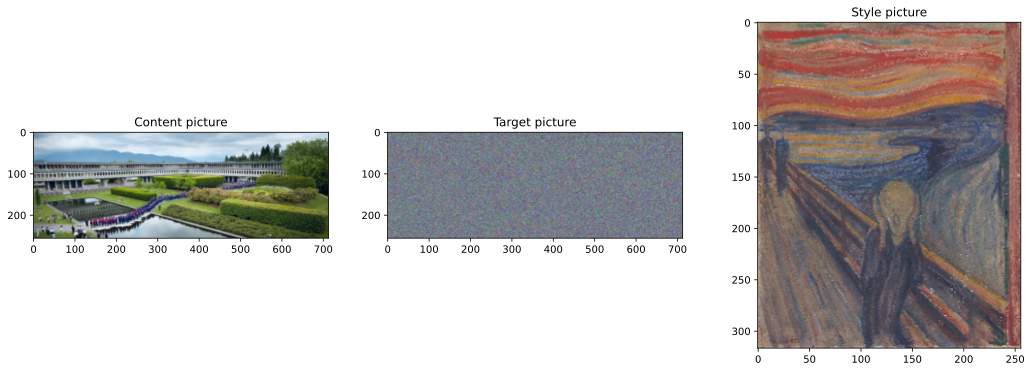

In [19]:
# Let's have a look at the "before" pics
fig,ax = plt.subplots(1,3,figsize=(18,6))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img4target.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')

plt.show()

# Functions to extract image feature map activations

In [25]:
# A function that returns feature maps

def getFeatureMapActs(img,net):
  
  # initialize feature maps as a list
  featuremaps = []
  featurenames = []

  convLayerIdx = 0

  # Task 3: loop over the layers of the network and extract the feature maps
  for layernum in range(len(net.features)):
    
    # process image in this layer
    net.to(device)
    img = net.features[layernum](img)

    #store the image if it's a conv2d layer
    if 'Conv2d' in str(net.features[layernum]):
      featuremaps.append(img)
      featurenames.append('ConvLayer_' + str(convLayerIdx))
      convLayerIdx += 1
  
  return featuremaps,featurenames

In [21]:
# A function that returns the Gram matrix of the feature activation map

def gram_matrix(M):
  
  # reshape to 2D
  _,chans,height,width = M.shape
  M = M.reshape(chans,height*width)  

  # compute and return covariance matrix
  # Task #4: compute the gram matrix (and normalize it by the number of elements)
  gram = torch.mm(M,M.t()) / (chans*width*height)
  return gram

In [26]:
# inspect the output of the function
featmaps,featnames = getFeatureMapActs(img4content,model)

# print out some info
for i in range(len(featnames)):
  print('Feature map "%s" is size %s'%(featnames[i],(featmaps[i].shape)))

Feature map "ConvLayer_0" is size torch.Size([1, 64, 256, 713])
Feature map "ConvLayer_1" is size torch.Size([1, 64, 256, 713])
Feature map "ConvLayer_2" is size torch.Size([1, 128, 128, 356])
Feature map "ConvLayer_3" is size torch.Size([1, 128, 128, 356])
Feature map "ConvLayer_4" is size torch.Size([1, 256, 64, 178])
Feature map "ConvLayer_5" is size torch.Size([1, 256, 64, 178])
Feature map "ConvLayer_6" is size torch.Size([1, 256, 64, 178])
Feature map "ConvLayer_7" is size torch.Size([1, 256, 64, 178])
Feature map "ConvLayer_8" is size torch.Size([1, 512, 32, 89])
Feature map "ConvLayer_9" is size torch.Size([1, 512, 32, 89])
Feature map "ConvLayer_10" is size torch.Size([1, 512, 32, 89])
Feature map "ConvLayer_11" is size torch.Size([1, 512, 32, 89])
Feature map "ConvLayer_12" is size torch.Size([1, 512, 16, 44])
Feature map "ConvLayer_13" is size torch.Size([1, 512, 16, 44])
Feature map "ConvLayer_14" is size torch.Size([1, 512, 16, 44])
Feature map "ConvLayer_15" is size torch

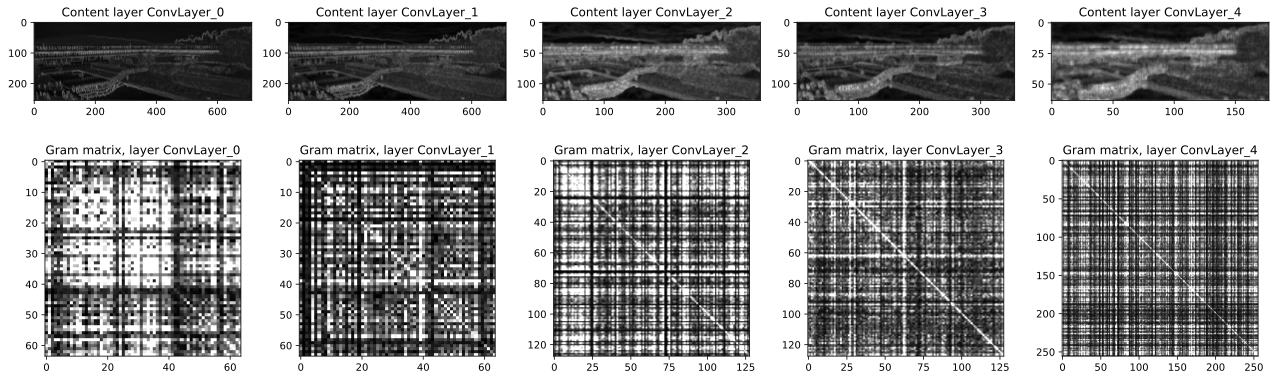

In [27]:
# let's see what the "content" image looks like
contentFeatureMaps,contentFeatureNames = getFeatureMapActs(img4content, model)


fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

  # average over all feature maps from this layer, and normalize
  pic = np.mean( contentFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='gray')
  axs[0,i].set_title('Content layer ' + str(contentFeatureNames[i]))


  ### now show the gram matrix
  pic = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='gray',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(contentFeatureNames[i]))

plt.tight_layout()
plt.show()

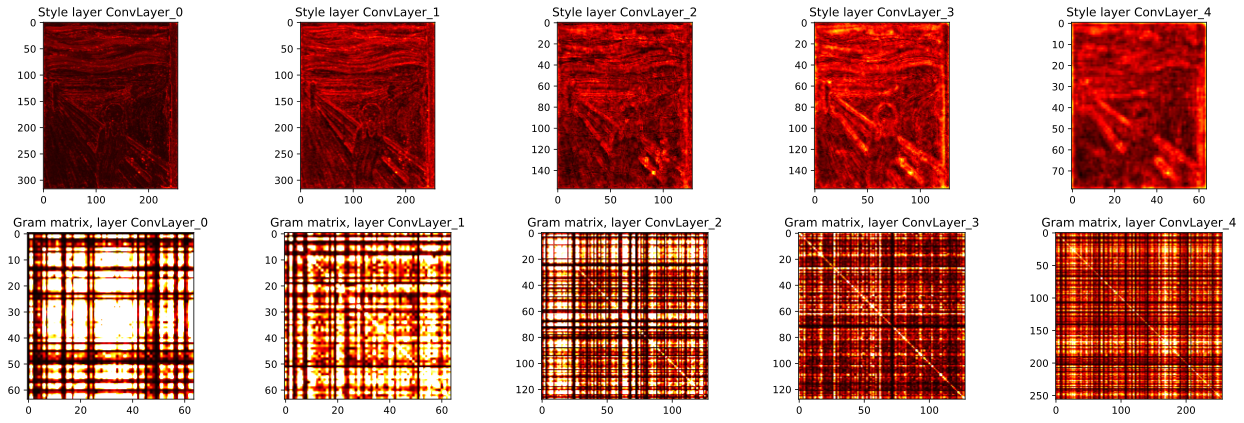

In [28]:

# repeat for the "style" image
styleFeatureMaps,styleFeatureNames = getFeatureMapActs(img4style,model)


fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

  # average over all feature maps from this layer, and normalize
  pic = np.mean( styleFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='hot')
  axs[0,i].set_title('Style layer ' + str(styleFeatureNames[i]))


  ### now show the gram matrix
  pic = gram_matrix(styleFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='hot',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(styleFeatureNames[i]))

plt.tight_layout()
plt.show()

# Now for the transfer

In [29]:
# which layers to use
layers4content = [ 'ConvLayer_1','ConvLayer_4' ]
layers4style   = [ 'ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4','ConvLayer_5' ]
weights4style  = [      1       ,     .5      ,     .5      ,     .2      ,     .1       ]

In [32]:
# make a copy of the target image and push to GPU
target = img4target.clone()
target.requires_grad = True
target = target.to(device)
styleScaling = 1e6

# number of epochs to train
numepochs = 1500

# optimizer for backprop
optimizer = torch.optim.RMSprop([target],lr=.005)


for epochi in range(numepochs):

  # extract the target feature maps
  targetFeatureMaps,targetFeatureNames = getFeatureMapActs(target,model)


  # initialize the individual loss components
  styleLoss = 0
  contentLoss = 0

  # loop over layers
  for layeri in range(len(targetFeatureNames)):

    # Task 5: Calculate the content loss and style loss for each layer
    if targetFeatureMaps[layeri] in layers4content:
      contentLoss += torch.mean((targetFeatureMaps[layeri]-contentFeatureMaps[layeri])**2)

    if targetFeatureNames[layeri] in layers4style:

      # Gram matrices
      Gtarget = gram_matrix(targetFeatureMaps[layeri])
      Gstyle  = gram_matrix(styleFeatureMaps[layeri])

      # compute their loss (de-weighted with increasing depth)
      styleLoss += torch.mean( (Gtarget-Gstyle)**2 ) * weights4style[layers4style.index(targetFeatureNames[layeri])]

  
  # combined loss
  combiloss = styleScaling*styleLoss + contentLoss

  # finally ready for backprop!
  optimizer.zero_grad()
  combiloss.backward()
  optimizer.step()


# Let's have a looksie!

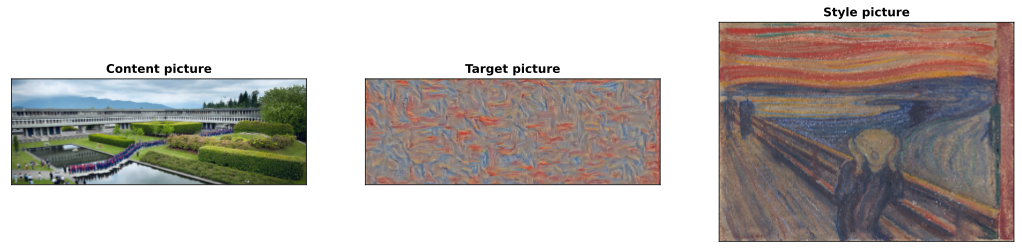

In [33]:
# the "after" pic
fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(pic)
ax[1].set_title('Target picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()